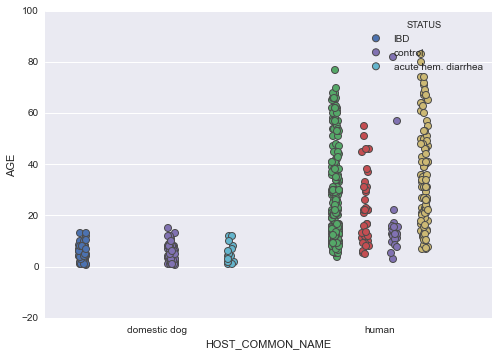

In [174]:
mf = load_mf('combined-gevers-suchodolski/mapping-file.standardized.txt')

mf.AGE = pd.to_numeric(mf.AGE, errors='coerce')

mf = mf[mf.BIOPSY_LOCATION.isin(['stool', 'no_data'])]

sns.stripplot('HOST_COMMON_NAME', 'AGE', data=mf, jitter=True,
              edgecolor='gray', hue='STATUS')

In [1]:
%matplotlib inline

import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt

from biom import load_table
from biom.util import biom_open

from qiime.parse import parse_mapping_file
from qiime.format import format_mapping_file
from skbio.io.util import open_file
from scipy.stats import pearsonr, spearmanr

def load_mf(fn):
    with open_file(fn, 'U') as f:
        mapping_data, header, _ = parse_mapping_file(f)
        _mapping_file = pd.DataFrame(mapping_data, columns=header)
        _mapping_file.set_index('SampleID', inplace=True)
    return _mapping_file

def write_mf(f, _df):
    with open_file(f, 'w') as fp:
        lines = format_mapping_file(['SampleID'] + _df.columns.tolist(),
                                    list(_df.itertuples()))
        fp.write(lines+'\n')

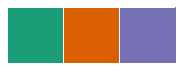

In [7]:
ibd_colors = sns.color_palette(["#d95f02", "#1b9e77", "#7570b3"])
sns.palplot(ibd_colors)

sns.set_palette(ibd_colors)

In [45]:
mf.HOST_COMMON_NAME.value_counts()

human           1957
domestic dog     192
Name: HOST_COMMON_NAME, dtype: int64

# Compute alpha diversity

In [35]:
!echo 'alpha_diversity:metrics PD_whole_tree,shannon,observed_species,chao1' > combined-gevers-suchodolski/alpha-params.txt
!echo 'make_rarefaction_plots:colorby HOST_COMMON_NAME,DISEASE_STAT' >> combined-gevers-suchodolski/alpha-params.txt

In [37]:
!alpha_rarefaction.py -i combined-gevers-suchodolski/otu-table.biom \
-o combined-gevers-suchodolski/alpha \
-m combined-gevers-suchodolski/mapping-file.standardized.txt \
-a -O 6 --min_rare_depth 15000 -e 15000 \
-p combined-gevers-suchodolski/alpha-params.txt \
-t gg_13_8_otus/trees/97_otus.tree

/Users/yoshikivazquezbaeza/.virtualenvs/qiime-191/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [42]:
!add_alpha_to_mapping_file.py -i combined-gevers-suchodolski/alpha/alpha_div_collated/PD_whole_tree.txt,\
combined-gevers-suchodolski/alpha/alpha_div_collated/chao1.txt,\
combined-gevers-suchodolski/alpha/alpha_div_collated/observed_species.txt,\
combined-gevers-suchodolski/alpha/alpha_div_collated/shannon.txt \
-m combined-gevers-suchodolski/mapping-file.standardized.txt \
-o combined-gevers-suchodolski/mapping-file.standardized.alpha.txt \
--depth 15000 --collated_input

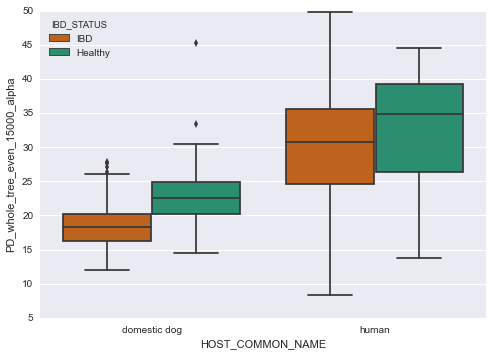

In [6]:
mf = load_mf('combined-gevers-suchodolski/mapping-file.standardized.alpha.amended.txt')

mf.PD_whole_tree_even_15000_alpha = pd.to_numeric(mf.PD_whole_tree_even_15000_alpha, errors='coerce')
mf.AGE = pd.to_numeric(mf.AGE, errors='coerce')

mf = mf[mf.BIOPSY_LOCATION.isin(['stool', 'no_data'])]

sns.boxplot('HOST_COMMON_NAME', 'PD_whole_tree_even_15000_alpha', hue='IBD_STATUS', data=mf)

plt.savefig('combined-gevers-suchodolski/alpha-diversity-comparison.pdf')

In [193]:
mf[mf.HOST_COMMON_NAME == 'human']['IBD_STATUS'].value_counts()

IBD        490
Healthy     30
Name: IBD_STATUS, dtype: int64

In [82]:
mf.HOST_COMMON_NAME.value_counts()

human           1957
domestic dog     192
Name: HOST_COMMON_NAME, dtype: int64

In [188]:
mf = load_mf('combined-gevers-suchodolski/mapping-file.standardized.alpha.txt')

def funk(row):
    if row['HOST_COMMON_NAME'] == 'human':
        # we want to standardize the values of this column
        if row['STATUS'] in {'UC', 'CD', 'IC'}:
            return 'IBD'
        else:
            return 'Healthy'
    elif row['HOST_COMMON_NAME'] == 'domestic dog':
        if row['STATUS'] == 'accute hem. diarrhea':
            return 'NA'
        elif row['STATUS'] == 'control':
            return 'Healthy'
        else:
            return 'IBD'
mf['IBD_STATUS'] = mf.apply(funk, axis=1, reduce=True)

write_mf('combined-gevers-suchodolski/mapping-file.standardized.alpha.amended.txt', mf)

In [197]:
mf.IBD_STATUS.value_counts()

IBD        584
Healthy    128
Name: IBD_STATUS, dtype: int64

In [198]:
mf.BIOPSY_LOCATION.value_counts()

stool      520
no_data    192
Name: BIOPSY_LOCATION, dtype: int64

In [211]:
rm -rf combined-gevers-suchodolski/ibd-comparison

In [215]:
%%bash

mkdir -p combined-gevers-suchodolski/ibd-comparison

for STAT in Healthy IBD
do
    filter_samples_from_otu_table.py -i combined-gevers-suchodolski/otu-table.15000.biom \
    -m combined-gevers-suchodolski/mapping-file.standardized.alpha.amended.txt \
    -s "IBD_STATUS:${STAT};BIOPSY_LOCATION:stool,no_data" \
    --output_fp combined-gevers-suchodolski/ibd-comparison/otu-table-${STAT}.15000.biom \
    --output_mapping_fp combined-gevers-suchodolski/ibd-comparison/mapping-file-${STAT}.15000.txt

    filter_otus_from_otu_table.py -s 50 \
    -i combined-gevers-suchodolski/ibd-comparison/otu-table-${STAT}.15000.biom \
    -o combined-gevers-suchodolski/ibd-comparison/otu-table-${STAT}.15000.40pct.biom

    summarize_taxa.py \
    -i combined-gevers-suchodolski/ibd-comparison/otu-table-${STAT}.15000.40pct.biom \
    -o combined-gevers-suchodolski/ibd-comparison/taxa-summaries-${STAT}-40pct \
    -m combined-gevers-suchodolski/ibd-comparison/mapping-file-${STAT}.15000.txt

    summarize_taxa.py \
    -i combined-gevers-suchodolski/ibd-comparison/otu-table-${STAT}.15000.40pct.biom \
    -o combined-gevers-suchodolski/ibd-comparison/taxa-summaries-${STAT}-40pct

    group_significance.py \
    -i combined-gevers-suchodolski/ibd-comparison/taxa-summaries-${STAT}-40pct/otu-table-${STAT}.15000.40pct_L6.biom \
    -m combined-gevers-suchodolski/ibd-comparison/mapping-file-${STAT}.15000.txt \
    -o combined-gevers-suchodolski/ibd-comparison/taxa-summaries-${STAT}-40pct/kruskall-wallis-L6-${STAT}.txt \
    -c HOST_COMMON_NAME
done

In [244]:
def intra_host_similarities(stats_a, stats_b):
    """Find the real similar taxa in group A vs group B
    
    Note that the samples that make up groups A and B can contain
    multiple sample types, but ultimately have to have a common
    shared category, this is the category that distinguishes group
    A and group B. The internal comparisons in group A and group B
    usually pertain to another subgrouping.
    
    Parameters
    ----------
    stats_a, stats_b : pd.DataFrame
        The output from comparing samples using group_significance.py

    Output
    ------
    pd.DataFrame
        The taxa that are shared between samples in group A as validated
        by the sharings in group B.
    """
    
    a_shared = stats_a[stats_a.Bonferroni_P >= 0.05]
    b_shared = stats_b[stats_b.Bonferroni_P >= 0.05]

    a_diff = stats_a[stats_a.Bonferroni_P < 0.05]
    b_diff = stats_b[stats_b.Bonferroni_P < 0.05]

    # si son iguales en a y en b quitalos de a y de b
    # si son diferentes en a y en b quitalos de a y de b

    out_a = pd.DataFrame()
    out_b = pd.DataFrame()
    
    removem = (set(a_shared.index.tolist()).intersection(b_shared.index.tolist()) |
               set(a_diff.index.tolist()).intersection(b_diff.index.tolist()))
    
    stats_a = stats_a[ ~stats_a.index.isin(removem) ].copy()
    stats_b = stats_b[ ~stats_b.index.isin(removem) ].copy()

    return stats_a, stats_b

In [261]:
healthy = pd.read_csv('combined-gevers-suchodolski/ibd-comparison/'
                      'taxa-summaries-Healthy-40pct/kruskall-wallis-L6-Healthy.txt', sep='\t', index_col='OTU')
ibd = pd.read_csv('combined-gevers-suchodolski/ibd-comparison/'
                  'taxa-summaries-IBD-40pct/kruskall-wallis-L6-IBD.txt', sep='\t', index_col='OTU')

ibd, healthy = intra_host_similarities(ibd, healthy)

sig = lambda x: x[((x['human_mean'] > 0.01) | (x['domestic dog_mean'] > 0.01)) & (x.Bonferroni_P < 0.05)]
not_sig = lambda y: y[((y['human_mean'] > 0.01) | (y['domestic dog_mean'] > 0.01)) & (y.Bonferroni_P >= 0.05)]

In [262]:
not_sig(ibd)

,Test-Statistic,P,FDR_P,Bonferroni_P,domestic dog_mean,human_mean
OTU,,,,,,
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__,10.917392,0.000953,0.001489,0.105745,0.063141,0.032218


In [263]:
not_sig(healthy)

,Test-Statistic,P,FDR_P,Bonferroni_P,domestic dog_mean,human_mean
OTU,,,,,,
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__,3.474687,0.062314,0.076695,1,0.084995,0.083907
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea,1.536256,0.215176,0.237436,1,0.006490,0.014271
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus,1.323294,0.250002,0.266669,1,0.003993,0.011886


In [264]:
sig(healthy)

,Test-Statistic,P,FDR_P,Bonferroni_P,domestic dog_mean,human_mean
OTU,,,,,,
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,49.873135,1.640151e-12,1.312121e-11,5.248482e-11,0.037109,0.000096
k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__[Eubacterium],48.906671,2.684362e-12,1.431660e-11,8.589957e-11,0.035785,0.001818
k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Allobaculum,40.846053,1.647056e-10,5.270579e-10,5.270579e-09,0.018358,0.000000
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__,14.616608,1.317483e-04,2.342192e-04,4.215946e-03,0.014723,0.083551


In [265]:
sig(ibd)

,Test-Statistic,P,FDR_P,Bonferroni_P,domestic dog_mean,human_mean
OTU,,,,,,
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__,123.995616,8.442992e-29,4.685860e-27,9.371721e-27,0.002892,0.053255
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus,122.395484,1.891198e-28,6.997434e-27,2.099230e-26,0.000094,0.026273
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Dialister,121.672811,2.722258e-28,7.554266e-27,3.021706e-26,0.000024,0.027159
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides,87.787891,7.286366e-21,6.221436e-20,8.087867e-19,0.000327,0.016624
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,68.597569,1.207528e-16,6.382650e-16,1.340357e-14,0.007185,0.047065
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus,56.035314,7.118092e-14,3.292117e-13,7.901082e-12,0.101545,0.012375
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__,39.768741,2.858841e-10,1.023650e-09,3.173314e-08,0.032471,0.082249
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,36.681292,1.391080e-09,4.541467e-09,1.544099e-07,0.063928,0.016479
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea,34.420806,4.439521e-09,1.406063e-08,4.927868e-07,0.005224,0.013265


We now seek to classify bacteria in four subgroups:
- **Different between species**: bacteria that are significantly different in healthy and diseased samples.
- **Similar between species**: bacteria that are not significantly different neither in healthy nor in diseased samples.
- **Core to IBD**: bacteria that are significantly different between healthy samples but not significantly different between diseased samples.
- **Core to Healthy** bacteria that are not significantly different between healthy samples but that are significantly different between diseased samples.

In [286]:
healthy = pd.read_csv('combined-gevers-suchodolski/ibd-comparison/'
                      'taxa-summaries-Healthy-40pct/kruskall-wallis-L6-Healthy.txt', sep='\t', index_col='OTU')
ibd = pd.read_csv('combined-gevers-suchodolski/ibd-comparison/'
                  'taxa-summaries-IBD-40pct/kruskall-wallis-L6-IBD.txt', sep='\t', index_col='OTU')

# the bacteria that distinguishes the species
different_between_species = (set(healthy[healthy.Bonferroni_P < 0.05].index) &
                             set(ibd[ibd.Bonferroni_P < 0.05].index))

# the bacteria that are in similar abundance for both species
same_between_species = (set(healthy[healthy.Bonferroni_P >= 0.05].index) &
                        set(ibd[ibd.Bonferroni_P >= 0.05].index))

# the bacteria that are core to IBD
core_ibd = (set(healthy[healthy.Bonferroni_P < 0.05].index) &
            set(ibd[ibd.Bonferroni_P >= 0.05].index))

# the bacteria that are core to healthy microbiomes
core_healthy = (set(healthy[healthy.Bonferroni_P >= 0.05].index) &
                set(ibd[ibd.Bonferroni_P < 0.05].index))

In [284]:
different_between_species

{'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella',
 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides',
 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__[Prevotella]',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Megamonas',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__[Mogibacteriaceae];g__',
 'k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__',
 'k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipel

In [285]:
same_between_species

{'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella',
 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus',
 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Turicibacterales;f__Turicibacteraceae;g__Turicibacter',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__SMB53',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Epulopiscium',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__[Ruminococcus]'}

In [280]:
core_healthy

{'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__'}

In [281]:
core_ibd

{'k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__[Eubacterium]',
 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium',
 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__'}